<a href="https://colab.research.google.com/github/NishilJ/CS-4372-ML-DS/blob/main/CS4372_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import zipfile
import io
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

In [ ]:
url = "https://www.kaggle.com/api/v1/datasets/download/fedesoriano/heart-failure-prediction"
response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall('/tmp/heart_failure_data')

csv_path = '/tmp/heart_failure_data/heart.csv'
df = pd.read_csv(csv_path)

In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [ ]:
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [ ]:
# convert categorical values to numerical with one hot encoding
df_enc = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df_enc = pd.get_dummies(df_enc, columns=['ChestPainType'], drop_first=True)
df_enc = pd.get_dummies(df_enc, columns=['RestingECG'], drop_first=True)
df_enc = pd.get_dummies(df_enc, columns=['ExerciseAngina'], drop_first=True)
df_enc = pd.get_dummies(df_enc, columns=['ST_Slope'], drop_first=True)

df_enc.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


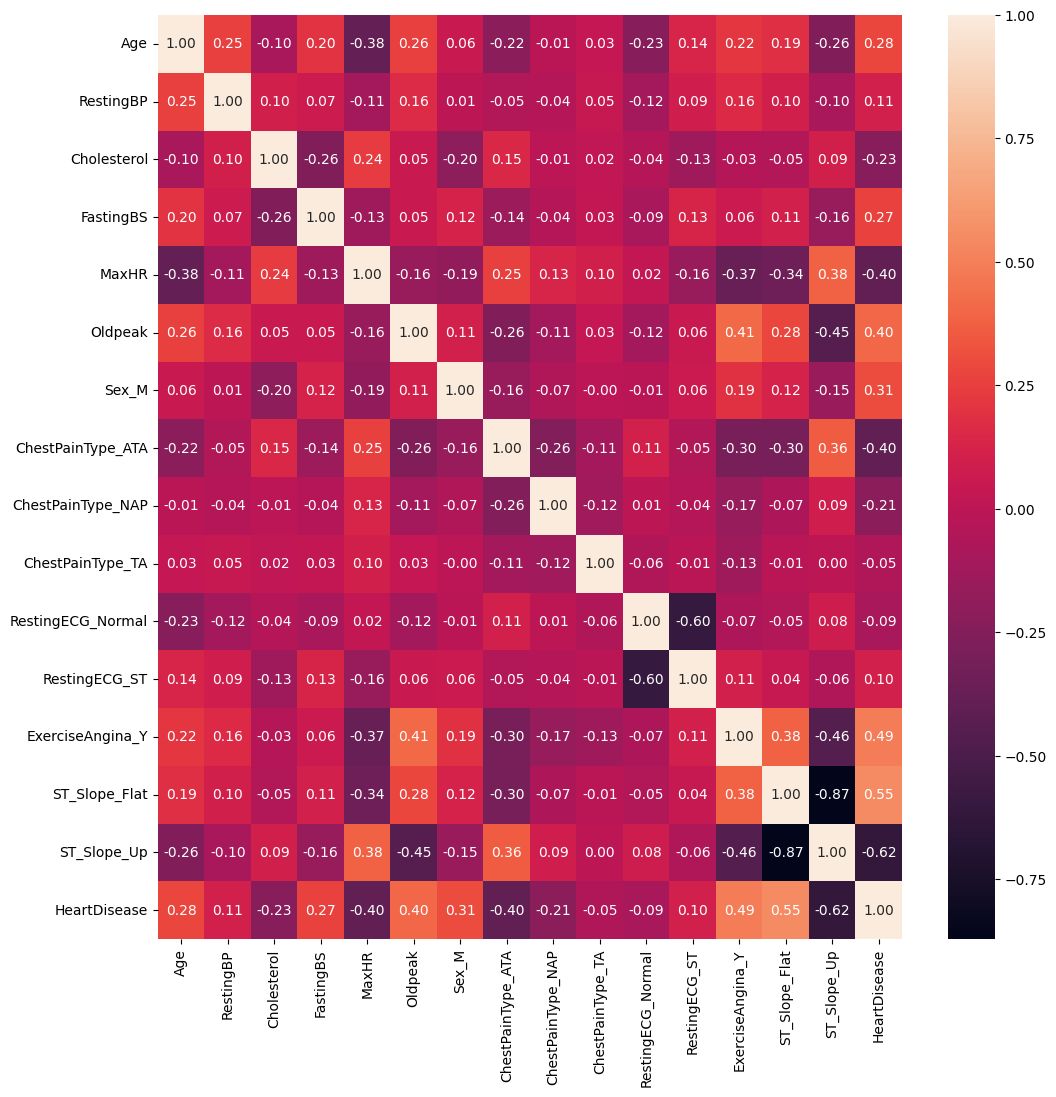

In [ ]:
# Put target var at the end for easier reading
cols = [c for c in df_enc.columns if c != "HeartDisease"] + ["HeartDisease"]
df_enc = df_enc[cols]

# Heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(df_enc.corr(), annot=True, fmt=".2f")
plt.show()

In [ ]:
X = df_enc.drop(columns=['HeartDisease'])
y = df_enc['HeartDisease']

# Select top 10 features using ANOVA F-value
selector = SelectKBest(score_func=f_classif)
selector.fit(X, y)

# Get scores as a Series for easy viewing
feat_scores = pd.Series(selector.scores_, index=X.columns)
feat_scores = feat_scores.sort_values(ascending=False)

print(feat_scores)

ST_Slope_Up          578.505658
ST_Slope_Flat        405.911473
ExerciseAngina_Y     296.144771
Oldpeak              178.615120
ChestPainType_ATA    176.482905
MaxHR                174.913585
Sex_M                 94.253184
Age                   79.160779
FastingBS             70.478543
Cholesterol           52.459725
ChestPainType_NAP     43.517481
RestingBP             10.727228
RestingECG_ST          9.731129
RestingECG_Normal      7.747367
ChestPainType_TA       2.758087
dtype: float64


In [ ]:
X = df_enc.drop(['HeartDisease', 'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'RestingBP'], axis=1)
y = df_enc['HeartDisease']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_dt.fit(X_train_scaled, y_train)

print(f"Best parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Best cross-validation accuracy for Decision Tree: {grid_search_dt.best_score_}")

best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test_scaled)

Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validation accuracy for Decision Tree: 0.7861522691268288


#Decision Tree Metrics

Decision Tree Metrics:
              precision    recall  f1-score   support

           0     0.7529    0.8312    0.7901        77
           1     0.8687    0.8037    0.8350       107

    accuracy                         0.8152       184
   macro avg     0.8108    0.8175    0.8125       184
weighted avg     0.8202    0.8152    0.8162       184



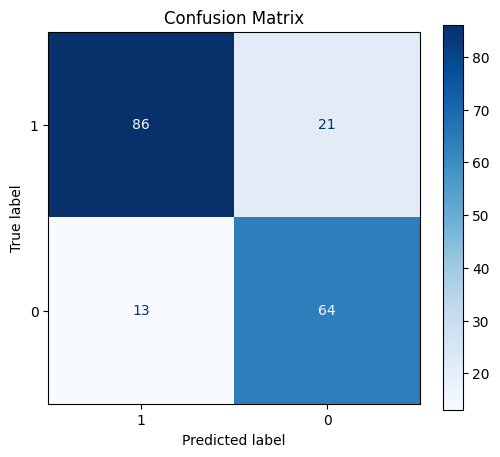

In [ ]:
print(f"Decision Tree Metrics:")
print(classification_report(y_test, y_pred_dt, digits=4))

# Confusion Matrix: [[TP, FN]
#                   [FP, TN]]
cm = confusion_matrix(y_test, y_pred_dt, labels=[1, 0])
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

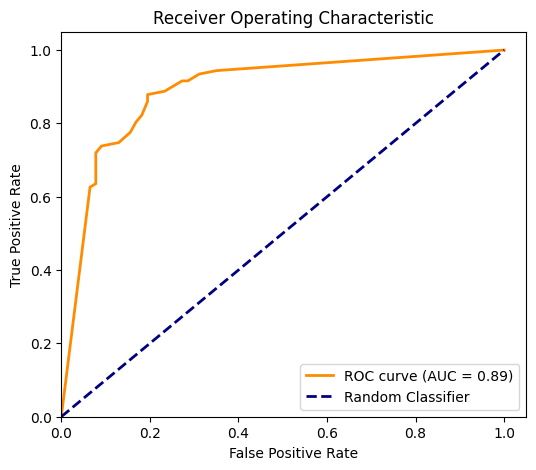

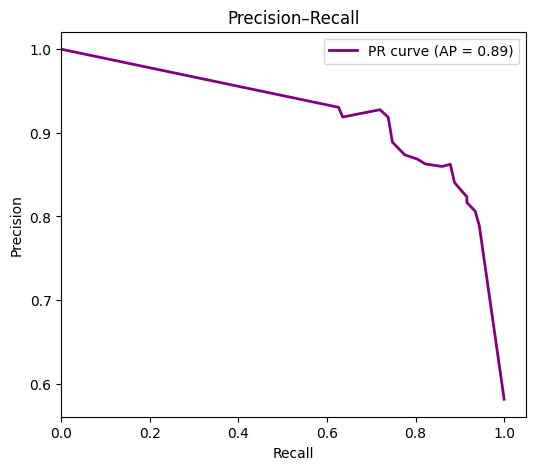

In [ ]:
# Get predicted probabilities
y_pred_prob_dt = best_dt_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate PR curve and AP
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_dt)
ap = average_precision_score(y_test, y_pred_prob_dt)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {ap:.2f})')
plt.xlim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall')
plt.legend()
plt.show()

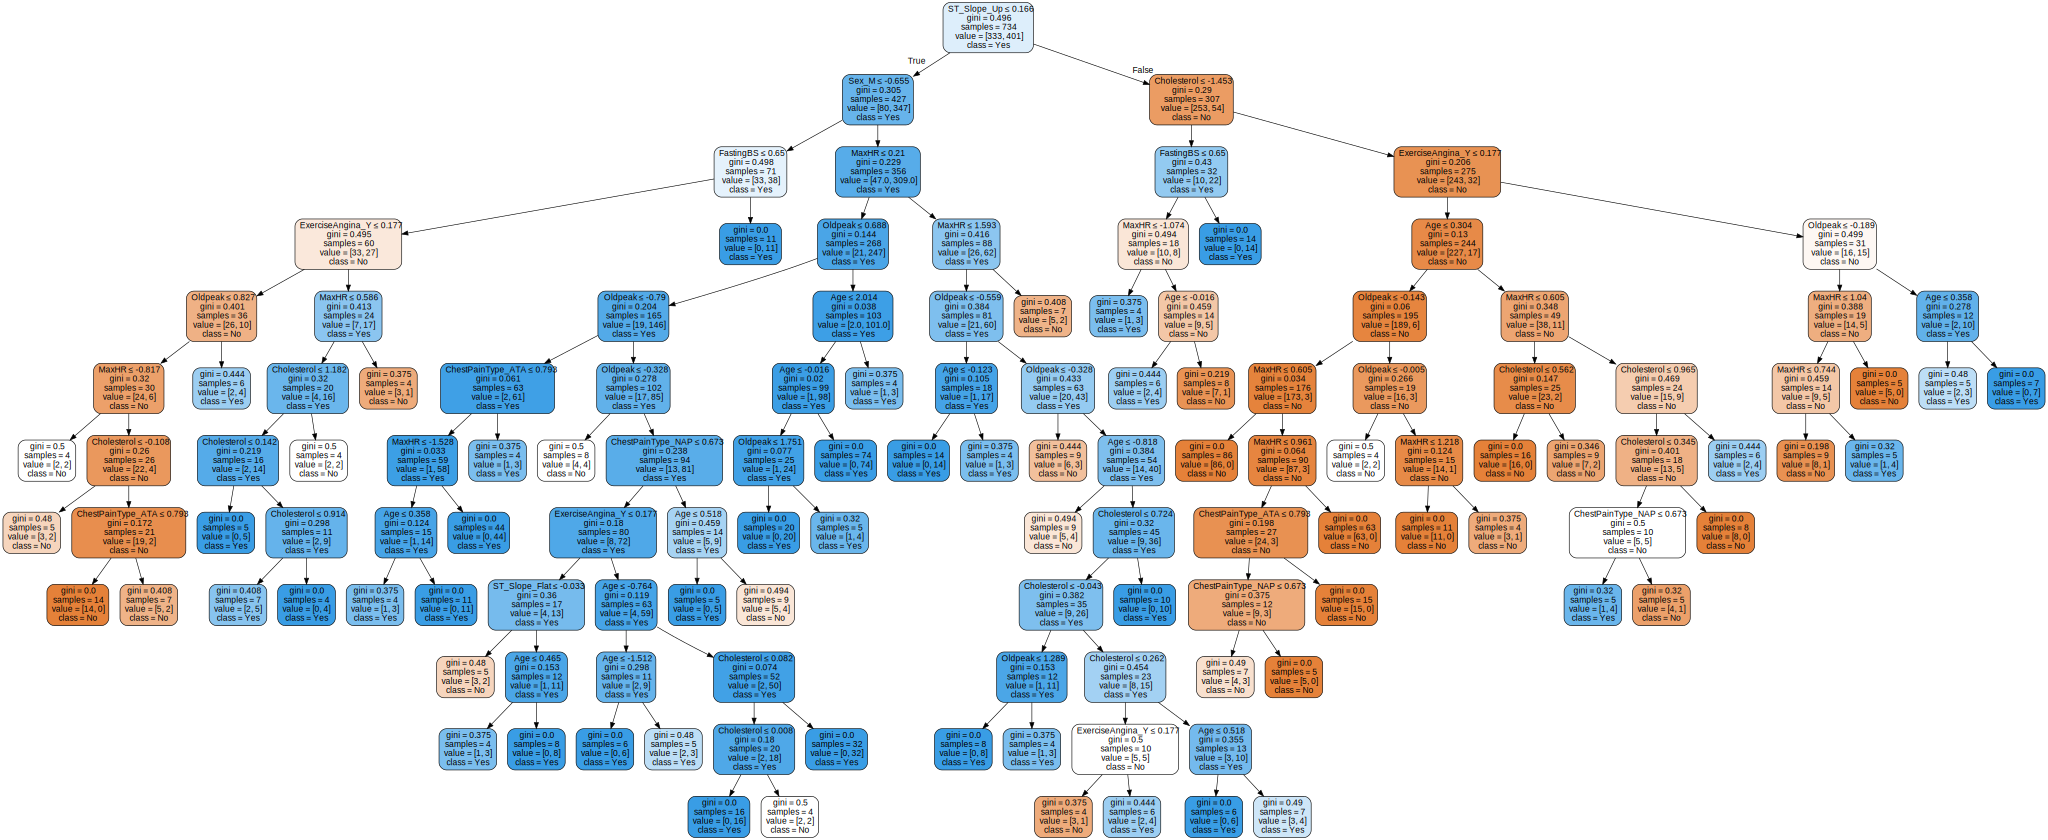

In [ ]:
dot_data = export_graphviz(
    best_dt_model,
    out_file=None,
    feature_names=X.columns,
    class_names=['No', 'Yes'],
    filled=True, rounded=True,
    special_characters=True,

)
graph = graphviz.Source(dot_data)
display(graph)

#Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best cross-validation accuracy for Random Forest: {grid_search_rf.best_score_}")

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy for Random Forest: 0.8814649147330165


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#Random Forest Metrics

Random Forest Metrics:
              precision    recall  f1-score   support

           0     0.8696    0.7792    0.8219        77
           1     0.8522    0.9159    0.8829       107

    accuracy                         0.8587       184
   macro avg     0.8609    0.8476    0.8524       184
weighted avg     0.8595    0.8587    0.8574       184



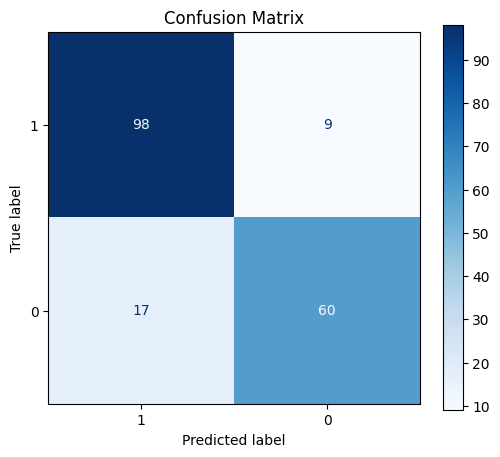

In [ ]:
print(f"Random Forest Metrics:")
print(classification_report(y_test, y_pred_rf, digits=4))

# Confusion Matrix: [[TP, FN]
#                   [FP, TN]]
cm = confusion_matrix(y_test, y_pred_rf, labels=[1, 0])
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


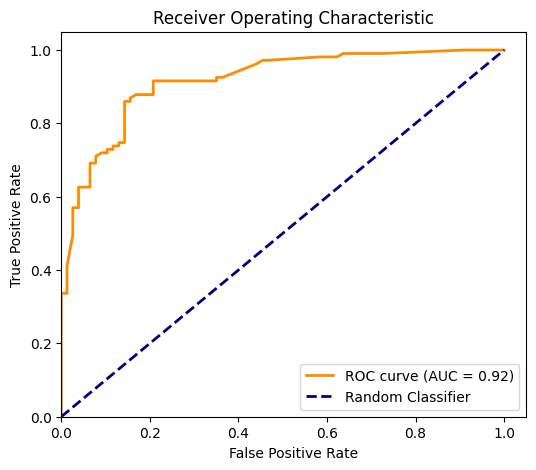

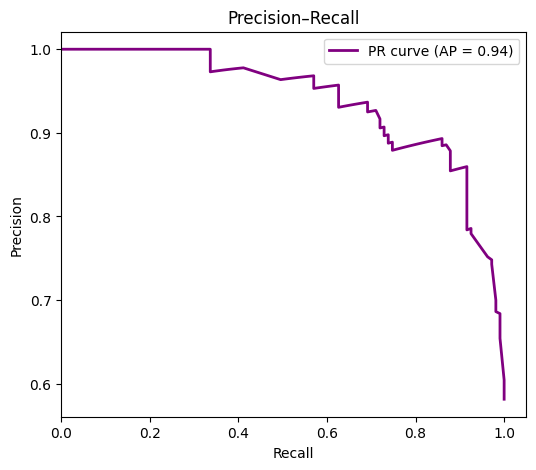

In [ ]:
# Get predicted probabilities
y_pred_prob_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate PR curve and AP
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_rf)
ap = average_precision_score(y_test, y_pred_prob_rf)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {ap:.2f})')
plt.xlim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall')
plt.legend()
plt.show()

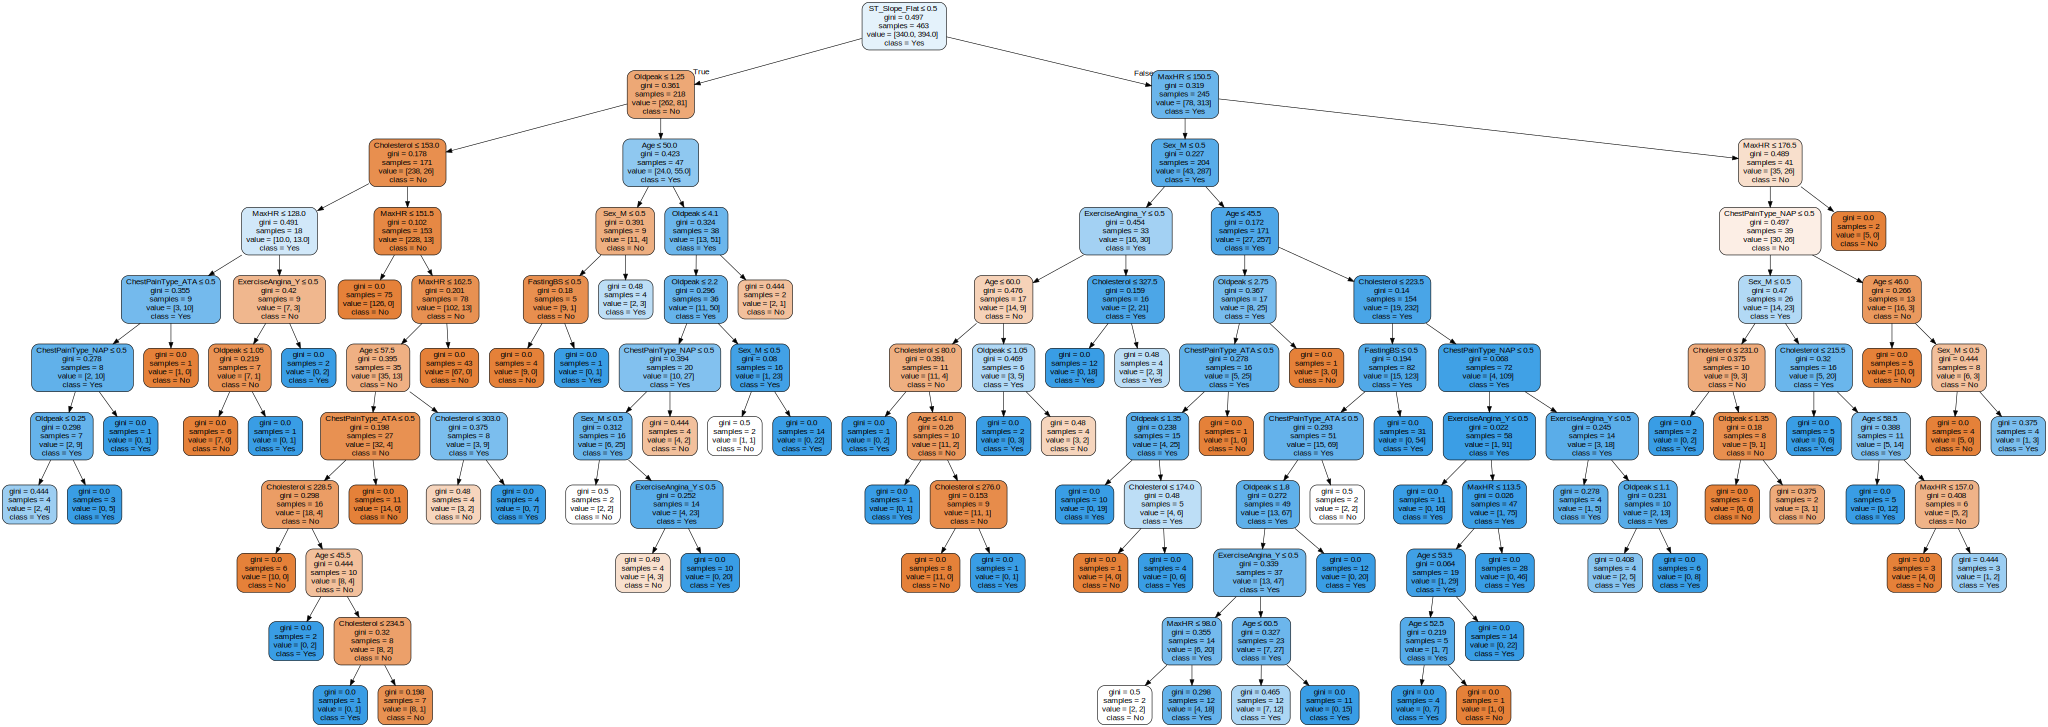

In [ ]:
dot_data_rf = export_graphviz(
              best_rf_model.estimators_[0],
              out_file=None,
              feature_names=X.columns,
              class_names=['No', 'Yes'],
              filled=True,
              rounded=True,
              special_characters=True)
graph_rf = graphviz.Source(dot_data_rf)
display(graph_rf)

#XGBoost

In [ ]:
xgb = XGBClassifier(random_state=42)

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)

print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best cross-validation accuracy for XGBoost: {grid_search_xgb.best_score_}")

best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation accuracy for XGBoost: 0.8773926008759668


#XGBoost Metrics

XGBoost Metrics:
              precision    recall  f1-score   support

           0     0.8286    0.7532    0.7891        77
           1     0.8333    0.8879    0.8597       107

    accuracy                         0.8315       184
   macro avg     0.8310    0.8205    0.8244       184
weighted avg     0.8313    0.8315    0.8302       184



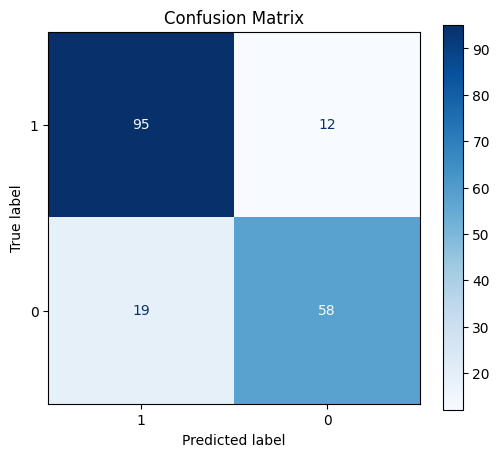

In [ ]:
print(f"XGBoost Metrics:")
print(classification_report(y_test, y_pred_xgb, digits=4))

# Confusion Matrix: [[TP, FN]
#                   [FP, TN]]
cm = confusion_matrix(y_test, y_pred_xgb, labels=[1, 0])
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

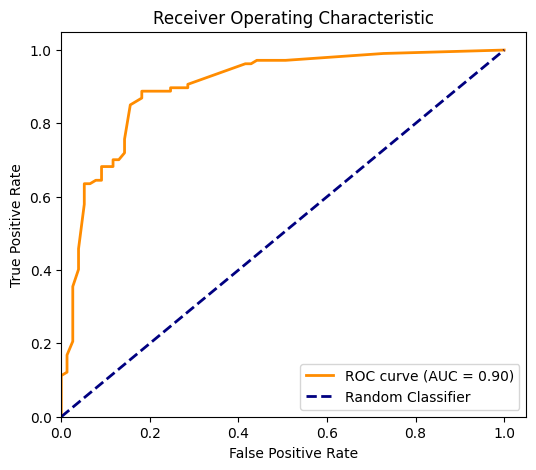

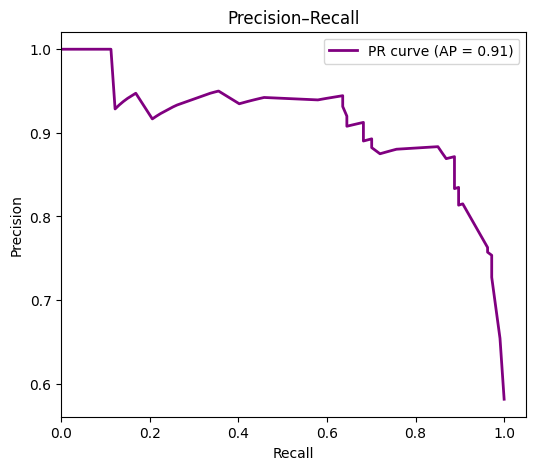

In [ ]:
# Get predicted probabilities
y_pred_prob_ada = best_ada_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate PR curve and AP
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_xgb)
ap = average_precision_score(y_test, y_pred_prob_xgb)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {ap:.2f})')
plt.xlim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall')
plt.legend()
plt.show()

#Adaboost

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [3, 5, 7]
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)

grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

best_ada_model = grid_search.best_estimator_
y_pred_ada = best_ada_model.predict(X_test_scaled)

Best parameters: {'estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}
Best cross-validation accuracy: 0.8719317864131954


#Adaboost Metrics

AdaBoost Metrics:
              precision    recall  f1-score   support

           0     0.8462    0.8571    0.8516        77
           1     0.8962    0.8879    0.8920       107

    accuracy                         0.8750       184
   macro avg     0.8712    0.8725    0.8718       184
weighted avg     0.8753    0.8750    0.8751       184



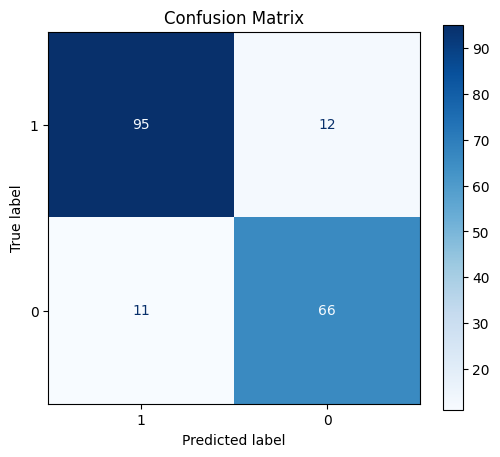

In [ ]:
print(f"AdaBoost Metrics:")
print(classification_report(y_test, y_pred_ada, digits=4))

# Confusion Matrix: [[TP, FN]
#                   [FP, TN]]
cm = confusion_matrix(y_test, y_pred_ada, labels=[1, 0])
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

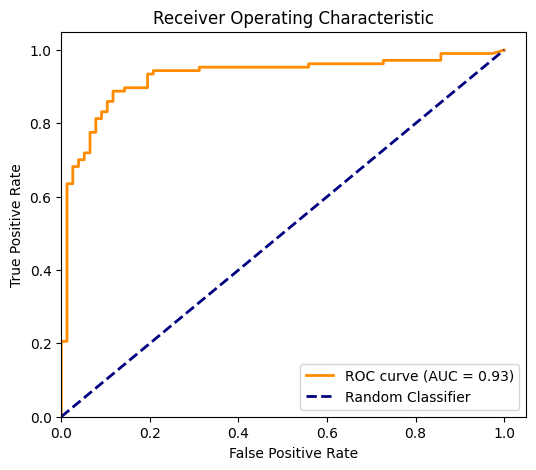

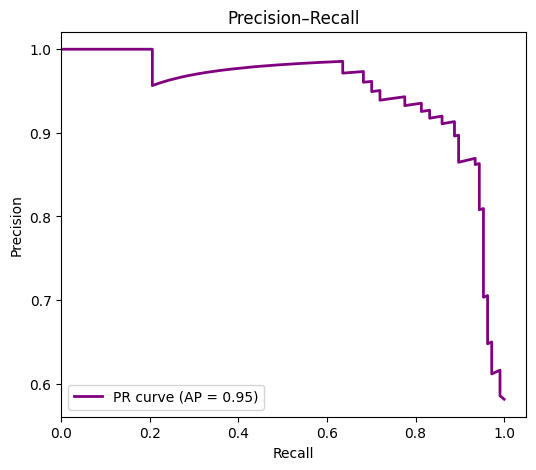

In [ ]:
# Get predicted probabilities
y_pred_prob_ada = best_ada_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_ada)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate PR curve and AP
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_ada)
ap = average_precision_score(y_test, y_pred_prob_ada)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {ap:.2f})')
plt.xlim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall')
plt.legend()
plt.show()

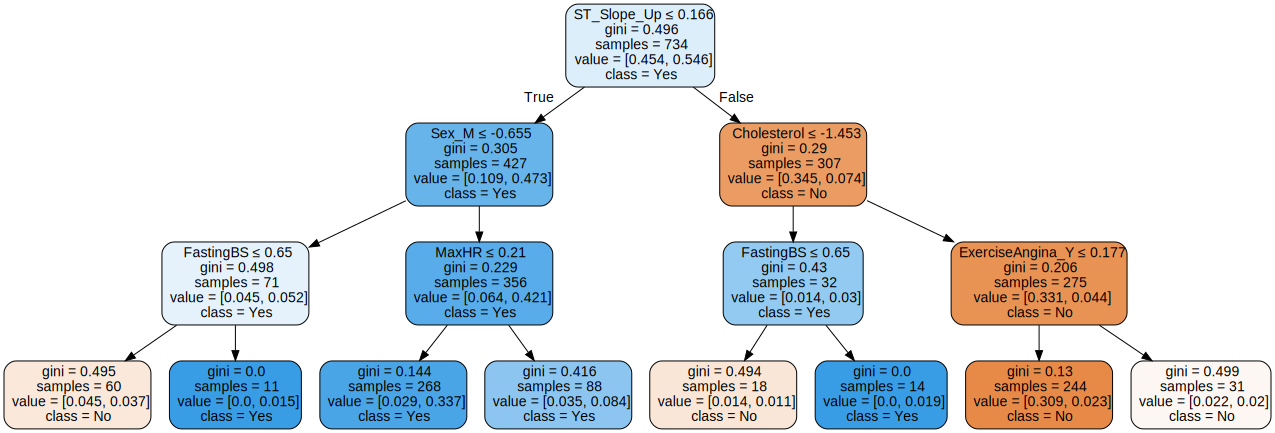

In [ ]:
dot_data_ada = export_graphviz(
              best_ada_model.estimators_[0],
              out_file=None,
              feature_names=X.columns,
              class_names=['No', 'Yes'],
              filled=True,
              rounded=True,
              special_characters=True)
graph_ada = graphviz.Source(dot_data_ada)
display(graph_ada)